# biLSTM Architecture (Part 3.3)
### This notebook prepares, trains and tests the Bidirectional Long Short-Term Memory (biLSTM) model architecture for sentiment classification

In [ ]:
! pip install datasets
! pip install nltk
! pip install gensim
! pip install huggingface-hub
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download("popular")
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import gensim.downloader as api
import numpy as np
from string import punctuation
from datasets import load_dataset
import string
from nltk.corpus import stopwords
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from nltk.tokenize import word_tokenize
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
import seaborn as sns
import math
import random
from itertools import product
import gc
import copy
import torch.nn.functional as F


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    | 

In [ ]:
from datasets import load_dataset

# Load the Rotten Tomatoes dataset with train, validation, and test splits
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']           # Training set
validation_dataset = dataset['validation'] # Validation set
test_dataset = dataset['test']             # Test set

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
# load a pre-trained Word2Vec model (e.g. "word2vec-google-news-300") from gensim's api
w2vmodel = api.load("fasttext-wiki-news-subwords-300")

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
# remove punctuation and stopwords
import string
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def tokenize_and_remove_punctuation_and_stopwords(text):
    tokens = word_tokenize(text)  # Tokenize the text
    tokens_no_punctuation_or_stopwords = [token for token in tokens if token not in string.punctuation and token not in stop_words]  # Remove punctuation
    return tokens_no_punctuation_or_stopwords

new_tokenized_texts = [tokenize_and_remove_punctuation_and_stopwords(text) for text in train_dataset['text']]

In [ ]:
# get all possible subwords of a word
def get_subwords(word):
    return [word[i:i+n] for n in range(1, len(word) + 1) for i in range(len(word) - n + 1)]


# Training and Evaluation Functions with Early Stopping and Visualization

This code includes the following main components:
1. **EarlyStopper**: A class for implementing early stopping, which helps prevent overfitting by stopping training when validation accuracy stops improving.
2. **train_model**: A function for training a model with optional OOV (out-of-vocabulary) handling, early stopping, and tracking training/validation loss and accuracy.
3. **evaluate_model**: A function for evaluating the model on a test set, displaying a confusion matrix, and calculating accuracy, precision, and F1 score.
4. **plot_loss**: A function for plotting training/validation loss and accuracy curves over epochs for visual analysis.

In [ ]:
# Class for early stopping to prevent overfitting when validation accuracy does not improve
class EarlyStopper:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience  # Number of epochs to wait for improvement
        self.counter = 0  # Tracks consecutive epochs with no improvement
        self.best_acc = 0  # Best validation accuracy observed so far
        self.verbose = verbose  # If True, print early stopping messages

    def early_stop(self, val_acc, model):
        if val_acc > self.best_acc:
            self.best_acc = val_acc  # Update best accuracy
            self.counter = 0  # Reset counter if validation accuracy improves
        else:
            self.counter += 1  # Increment counter if no improvement

        if self.counter >= self.patience:
            if self.verbose:
                print("Early stopping...")  # Print message if stopping
            return True
        return False

# Function to train the model with early stopping and optional OOV handling
def train_model(model, epochs, criterion, optimizer, train_loader, validation_loader, handle_oov=False, earlystopper=EarlyStopper(patience=5, verbose=True)):
    train_loss_history = []  # Track training loss per epoch
    train_accuracy_history = []  # Track training accuracy per epoch
    val_loss_history = []  # Track validation loss per epoch
    val_accuracy_history = []  # Track validation accuracy per epoch
    best_model = model.state_dict()  # Store best model based on validation accuracy
    best_val_accuracy = 0.0  # Initialize best validation accuracy

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch'):
            if isinstance(labels, list):
                labels = torch.tensor(labels)
            if handle_oov:
                labels = labels.to(device)
            else:
                inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Count correct predictions
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)  # Compute average training loss
        train_accuracy = correct / total  # Compute training accuracy
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in validation_loader:
                if isinstance(labels, list):
                    labels = torch.tensor(labels)
                if handle_oov:
                    labels = labels.to(device)
                else:
                    inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                total_loss += loss.item()

        val_loss = total_loss / len(validation_loader)  # Compute average validation loss
        val_accuracy = correct / total  # Compute validation accuracy
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")
        print("-" * 60)

        # Early stopping based on validation accuracy
        if earlystopper.early_stop(val_accuracy, model):
            break

        # Save the best model
        if val_accuracy >= best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = copy.deepcopy(model)

    model = copy.deepcopy(best_model)  # Restore best model

    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history, model

# Function to evaluate the model on the test set with optional OOV handling
def evaluate_model(model, test_loader, handle_oov=False):
    model.eval()  # Set model to evaluation mode
    correct, total = 0, 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            if isinstance(labels, list):
                labels = torch.tensor(labels)
            if handle_oov:
                labels = labels.to(device)
            else:
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total  # Overall accuracy
    print(f'Test Accuracy: {accuracy:.2f}')

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate and print additional metrics
    TN, FP, FN, TP = cm.ravel()
    precision = precision_score(all_labels, all_predictions, average='binary')
    f1 = f1_score(all_labels, all_predictions, average='binary')

    print(f'True Positives (TP): {TP}')
    print(f'True Negatives (TN): {TN}')
    print(f'False Positives (FP): {FP}')
    print(f'False Negatives (FN): {FN}')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'F1 Score: {f1:.2f}')

    return accuracy

# Function to plot training and validation loss and accuracy over epochs
def plot_loss(train_loss, train_accuracy, val_loss, val_accuracy_history, title='Training Curves'):
    epochs = np.arange(1, len(train_loss) + 1)  # List of epoch numbers

    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss', color='blue', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange', linewidth=2)
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(ticks=np.arange(1, len(train_loss) + 1, step=max(1, len(epochs) // 10)))
    plt.legend()
    plt.grid(True)

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(epochs, val_accuracy_history, label='Validation Accuracy', color='orange', linewidth=2)
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks(ticks=np.arange(1, len(train_loss) + 1, step=max(1, len(epochs) // 10)))
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
import gc
import copy
import torch.optim as optim
import torch.nn as nn

def train_with_fixed_params(model_type, hidden_size, learning_rate, batch_size, num_epochs, dropout, num_layers, train_embeddings_bool=False, handle_oov=False):
    # Define input dimensions and output classes for the model
    input_dim = 300  # Embedding dimension
    output_size = 2  # Binary classification output size


    print(f"Running with fixed parameters: hidden_size={hidden_size}, lr={learning_rate}, "
          f"batch_size={batch_size}, epochs={num_epochs}, dropout={dropout}, num_layers={num_layers}")

    # Clear CUDA cache if GPU is available to free memory
    if torch.cuda.device_count() >= 1:
        gc.collect()
        torch.cuda.empty_cache()

    # Model selection based on the specified model_type
    if model_type == "BiLSTM":
        # Initialize BiLSTM model with specified parameters
        model = BiLSTM(
            embeddings=w2vmodel.vectors, input_dim=input_dim, hidden_size=hidden_size,
            output_size=output_size, num_layers=num_layers, dropout=dropout,
            train_embeddings=train_embeddings_bool
        )
    elif model_type == "BiGRU":
        # Initialize BiGRU model with specified parameters
        model = BiGRU(
            input_dim=input_dim, hidden_size=hidden_size, output_size=output_size,
            num_layers=num_layers, dropout=dropout, word2vec_model=w2vmodel,
            train_embeddings=train_embeddings_bool
        )
    elif model_type == "RNNNonOOV":
        # Initialize simple RNN model without OOV handling
        model = RNNNonOOV(
            input_dim, hidden_size, output_size, w2vmodel.vectors,
            train_embeddings=train_embeddings_bool
        )
    elif model_type == "RNNOOV":
        # Initialize simple RNN model with OOV handling
        model = RNNOOV(
            input_dim, hidden_size, output_size, w2vmodel.vectors,
            train_embeddings=train_embeddings_bool
        )
    else:
        # Raise error if model_type is not recognized
        raise ValueError(f"Model '{model_type}' not found. Choose from: BiLSTM, BiGRU, RNNNonOOV, RNNOOV")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    model.to(device)  # Move model to GPU if available
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model and record training/validation history
    train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history, best_model = train_model(
        model, num_epochs, criterion, optimizer, train_loader, validation_loader, handle_oov=handle_oov
    )

    # Capture best metrics from validation history
    best_val_accuracy = max(val_accuracy_history)
    best_train_accuracy = max(train_accuracy_history)
    best_val_loss = min(val_loss_history)

    # Collect all relevant training metrics in a dictionary
    results = {
        'train_loss_history': train_loss_history,
        'train_accuracy_history': train_accuracy_history,
        'val_loss_history': val_loss_history,
        'val_accuracy_history': val_accuracy_history,
        'best_val_accuracy': best_val_accuracy,
        'best_train_accuracy': best_train_accuracy,
        'best_val_loss': best_val_loss,
    }

    # Return the model with the best validation performance and training results
    return best_model, results


In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch

# Custom Dataset class to handle texts and labels
class SentimentDatasetWithText(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts  # List of preprocessed texts
        self.labels = labels  # Corresponding labels for each text

    def __len__(self):
        return len(self.labels)  # Returns the number of samples in the dataset

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]  # Returns a text-label pair

# Function to create data loaders with OOV handling
def create_data_loaders_with_oov_handling(dataset, batch_size):
    # Preprocess and tokenize texts for train, validation, and test sets
    train_texts = [tokenize_and_remove_punctuation_and_stopwords(text) for text in dataset['train']['text']]
    validation_texts = [tokenize_and_remove_punctuation_and_stopwords(text) for text in dataset['validation']['text']]
    test_texts = [tokenize_and_remove_punctuation_and_stopwords(text) for text in dataset['test']['text']]

    # Create Dataset objects for each split
    train_dataset = SentimentDatasetWithText(train_texts, dataset['train']['label'])
    validation_dataset = SentimentDatasetWithText(validation_texts, dataset['validation']['label'])
    test_dataset = SentimentDatasetWithText(test_texts, dataset['test']['label'])

    # Initialize DataLoaders with a custom collate function for batching
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

    return train_loader, validation_loader, test_loader  # Return DataLoaders for each dataset split

# Custom collate function to handle batching of texts and labels
def collate_fn(batch):
    texts, labels = zip(*batch)  # Separate texts and labels
    return list(texts), torch.tensor(labels)  # Return texts as list and labels as tensor


In [ ]:
# Initialize data loaders for training, validation, and testing sets with a batch size of 64
train_loader, validation_loader, test_loader = create_data_loaders_with_oov_handling(dataset, 64)

## BiLSTM Model Architecture

This model is a BiLSTM (Bidirectional Long Short-Term Memory) network designed for sequence-based tasks, with an added mechanism for handling out-of-vocabulary (OOV) words using subwords.

---

#### 1. Model Architecture
- **Embedding Layer**:
  - Initializes with pre-trained embeddings, with an option to make them trainable. Embeddings are loaded using `nn.Embedding.from_pretrained`, and the `train_embeddings` parameter controls whether they remain static or are updated during training.
  
- **LSTM Layer**:
  - A bidirectional LSTM layer processes the sequence data. The `hidden_size` determines the capacity of the LSTM units, while the `num_layers` parameter sets the number of stacked LSTM layers. When `bidirectional=True`, it uses both forward and backward sequences, effectively doubling the hidden size in the output.

- **Fully Connected Layer**:
  - After the LSTM, a fully connected layer (`fc`) maps the final hidden state(s) to the output size, making it suitable for tasks like classification.

---

#### 2. Operational Mechanism
- **Subword-Based OOV Handling**:
  - The `encode_with_subwords` method generates embeddings for OOV words by breaking them down into subwords. For each OOV word, it checks if any subwords are present in the pre-trained vocabulary, then averages their embeddings to create a representative embedding. If no subwords are found, it returns a zero vector.
  
- **Sequence Embedding**:
  - During the forward pass, each sentence is processed word by word. Known words are directly embedded, while unknown words are handled by `encode_with_subwords`.
  - Sentence embeddings are padded to ensure consistency in batch processing.

- **LSTM Processing**:
  - The padded embeddings are passed through the LSTM layer, producing output for each time step. If the LSTM is bidirectional, the output from both directions is concatenated.

- **Final Hidden State**:
  - The model takes the hidden state from the last time step of both the forward and backward passes for bidirectional LSTM. If it’s unidirectional, only the last hidden state is used.

- **Output Layer**:
  - The final hidden state(s) are passed through the fully connected layer, which generates the output logits.

---

#### 3. Design Rationale
- **Bidirectional LSTM**: Using a bidirectional LSTM allows the model to capture context from both past and future sequences, which can be beneficial for understanding dependencies within the sequence.
- **Subword Encoding for OOV Words**: By representing OOV words using subwords, the model can handle unknown tokens more effectively.
- **Flexible Embeddings**: For our purpose, the embeddings are set to be trainable later on.



In [ ]:
import torch
import torch.nn as nn

# The BiLSTM model class
class BiLSTM(nn.Module):
    def __init__(self, embeddings, input_dim, hidden_size, output_size, dropout, num_layers=1, bidirectional=True, train_embeddings=False, word2vec_model=w2vmodel):
        super(BiLSTM, self).__init__()

        # Initialize the embedding layer with pre-trained embeddings, optionally trainable
        self.embeddings = nn.Embedding.from_pretrained(torch.tensor(embeddings, dtype=torch.float32), freeze=not train_embeddings, sparse=False)
        self.embedding_dim = embeddings.shape[1]  # Dimension of each embedding

        # Define the LSTM layer with the specified parameters
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout
        )

        # Fully connected layer for output, doubling hidden size if bidirectional
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

        # Dictionary mapping words to indices for subword handling
        self.word_to_index = word2vec_model.key_to_index

    # Method to handle out-of-vocabulary (OOV) words using subword embeddings
    def encode_with_subwords(self, word, device):
        # Get subwords for the given word
        subwords = get_subwords(word)

        # Collect indices of subwords present in the vocabulary
        subword_indices = [
            self.word_to_index[subword]
            for subword in subwords if subword in self.word_to_index
        ]

        # If valid subwords are found, calculate the average embedding
        if subword_indices:
            subword_tensor = torch.tensor(subword_indices, device=device)
            subword_embeddings = self.embeddings(subword_tensor)
            return subword_embeddings.mean(dim=0)  # Return mean embedding
        else:
            # Return a zero vector if no subwords are found
            return torch.zeros(self.embeddings.embedding_dim, device=device)

    # Forward pass of the model
    def forward(self, x):
        device = next(self.parameters()).device  # Get the device (CPU/GPU)
        batch_embeddings = []  # List to store embeddings for each sentence

        # Process each sentence in the batch
        for sentence in x:
            sentence_embeddings = []  # List to store embeddings for each word in the sentence

            # Process each word in the sentence
            for word in sentence:
                if word in self.word_to_index:
                    # Get embedding for known words
                    word_idx = torch.tensor(self.word_to_index[word], device=device)
                    word_embedding = self.embeddings(word_idx)
                else:
                    # Encode OOV words using subwords
                    word_embedding = self.encode_with_subwords(word, device)
                sentence_embeddings.append(word_embedding)  # Add word embedding to sentence

            # Stack embeddings for the sentence and add to batch
            sentence_embeddings = torch.stack(sentence_embeddings)
            batch_embeddings.append(sentence_embeddings)

        # Pad sentences in the batch to equal lengths for LSTM processing
        batch_embeddings = torch.nn.utils.rnn.pad_sequence(batch_embeddings, batch_first=True)

        # Pass the batch through the LSTM layer
        lstm_out, _ = self.lstm(batch_embeddings)

        # For bidirectional LSTM, concatenate final hidden states from both directions
        if self.lstm.bidirectional:
            final_hidden = torch.cat((lstm_out[:, -1, :self.lstm.hidden_size], lstm_out[:, 0, self.lstm.hidden_size:]), dim=-1)
        else:
            # For unidirectional LSTM, use the last hidden state
            final_hidden = lstm_out[:, -1, :]

        # Pass final hidden state through the fully connected layer for output
        out = self.fc(final_hidden)
        return out


Running with fixed parameters: hidden_size=128, lr=0.001, batch_size=128, epochs=100, dropout=0.5, num_layers=1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
Epoch 1/100: 100%|██████████| 134/134 [05:31<00:00,  2.48s/batch]


Epoch 1/100 | Train Loss: 0.5578 | Train Accuracy: 0.7054 | Val Loss: 0.4721 | Val Accuracy: 0.7692
------------------------------------------------------------


Epoch 2/100: 100%|██████████| 134/134 [05:31<00:00,  2.48s/batch]


Epoch 2/100 | Train Loss: 0.2601 | Train Accuracy: 0.8947 | Val Loss: 0.5353 | Val Accuracy: 0.7542
------------------------------------------------------------


Epoch 3/100: 100%|██████████| 134/134 [05:31<00:00,  2.48s/batch]


Epoch 3/100 | Train Loss: 0.0980 | Train Accuracy: 0.9659 | Val Loss: 0.8050 | Val Accuracy: 0.7523
------------------------------------------------------------


Epoch 4/100: 100%|██████████| 134/134 [05:31<00:00,  2.48s/batch]


Epoch 4/100 | Train Loss: 0.0455 | Train Accuracy: 0.9846 | Val Loss: 0.9136 | Val Accuracy: 0.7439
------------------------------------------------------------


Epoch 5/100: 100%|██████████| 134/134 [05:31<00:00,  2.48s/batch]


Epoch 5/100 | Train Loss: 0.0418 | Train Accuracy: 0.9866 | Val Loss: 1.1549 | Val Accuracy: 0.7308
------------------------------------------------------------


Epoch 6/100: 100%|██████████| 134/134 [05:31<00:00,  2.48s/batch]


Epoch 6/100 | Train Loss: 0.0181 | Train Accuracy: 0.9953 | Val Loss: 1.2418 | Val Accuracy: 0.7355
------------------------------------------------------------
Early stopping...
Fixed Parameters: {'model_type': 'BiLSTM', 'hidden_size': 128, 'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 100, 'dropout': 0.5, 'num_layers': 1, 'train_embeddings_bool': True, 'handle_oov': True}
Best Validation Loss: 0.4721
Best Validation Accuracy: 0.7692
Best Training Accuracy: 0.9953


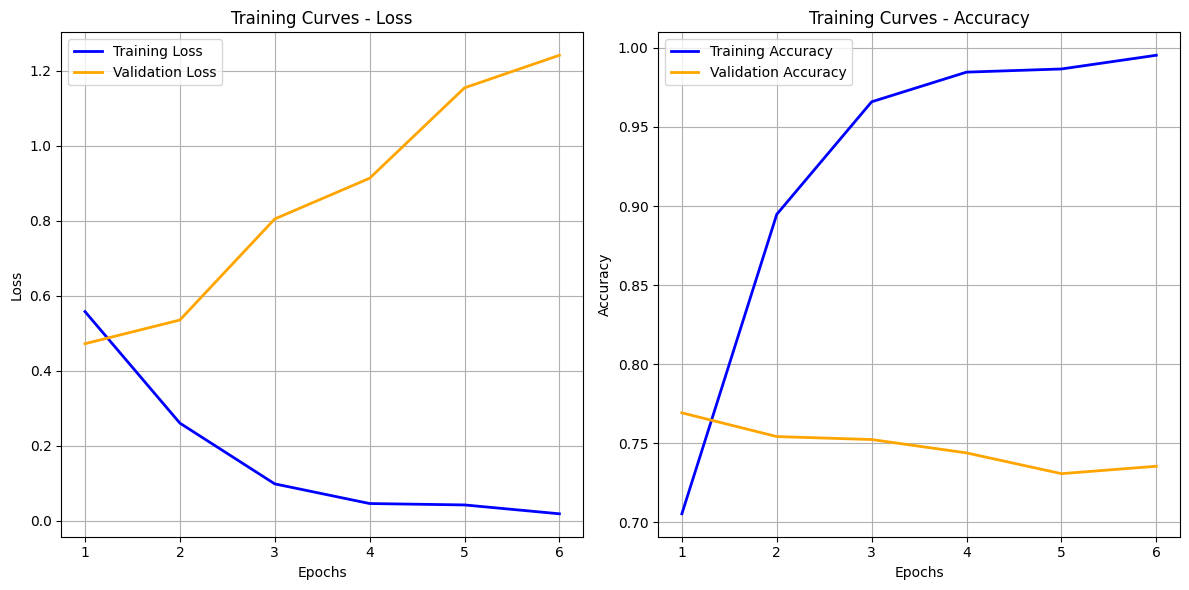

In [ ]:
# Set device to GPU if available; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a dictionary of fixed hyperparameters for the BiLSTM model
fixed_params = {
    'model_type': 'BiLSTM',             # Specify model type as BiLSTM
    'hidden_size': 128,                 # Set hidden layer size for the LSTM
    'learning_rate': 0.001,             # Learning rate for optimizer
    'batch_size': 128,                  # Define batch size for training
    'num_epochs': 100,                  # Number of epochs for training
    'dropout': 0.5,                     # Dropout rate for regularization
    'num_layers': 1,                    # Number of LSTM layers
    'train_embeddings_bool': True,      # Allow embeddings to be trainable
    'handle_oov': True                  # Enable OOV handling using subwords
}

# Train the model using the specified fixed parameters and return the best model and results
best_model, results = train_with_fixed_params(**fixed_params)

# Print the fixed parameters used for training
print(f"Fixed Parameters: {fixed_params}")
# Print the best validation loss achieved during training
print(f"Best Validation Loss: {results['best_val_loss']:.4f}")
# Print the best validation accuracy achieved during training
print(f"Best Validation Accuracy: {results['best_val_accuracy']:.4f}")
# Print the best training accuracy achieved during training
print(f"Best Training Accuracy: {results['best_train_accuracy']:.4f}")

# Plot training and validation loss and accuracy history over epochs
plot_loss(
    results['train_loss_history'],
    results['train_accuracy_history'],
    results['val_loss_history'],
    results['val_accuracy_history']
)


### Training Results Analysis

- **Accuracy**:
  - The training accuracy reached over 99% within the first few epochs, indicating that the model is highly effective at capturing patterns in the training data.
  - However, the validation accuracy, which started at 0.7692, gradually declined and stabilized around 0.73 by the sixth epoch. This divergence between training and validation accuracy suggests overfitting, where the model performs well on training data but struggles to generalize to unseen data.

- **Loss**:
  - Training loss decreased rapidly, nearing zero by the sixth epoch, which is consistent with the high training accuracy.
  - Validation loss, on the other hand, started at a low value of 0.4721 and progressively increased, reaching 1.24 by the sixth epoch. This contrast—decreasing training loss with increasing validation loss—further indicates overfitting.

- **Early Stopping**:
  - Early stopping was applied after six epochs, as further training did not improve validation performance. This intervention helps prevent the model from fitting the training data even more tightly, which could further degrade validation accuracy.

- **Justification for Overfitting**:
  - This configuration (with `hidden_size=128`, `dropout=0.5`, and `num_layers=1`) was selected after extensive hyperparameter tuning over various combinations. Other setups presented their own performance trade-offs. For instance:
    - Higher dropout or smaller hidden sizes reduced overfitting but also lowered the model's overall accuracy.
    - Lower complexity setups underfit the data, failing to achieve meaningful accuracy even on the training set.
  - Given these trade-offs, this configuration provided the best balance among available options, achieving high training performance and a reasonable starting validation accuracy.



In [ ]:
evaluate_model(best_model,test_loader,True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


Test Accuracy: 0.78


True Positives (TP): 419
True Negatives (TN): 415
False Positives (FP): 118
False Negatives (FN): 114
Accuracy: 0.78
Precision: 0.78
F1 Score: 0.78


0.7823639774859287

### Test Results Analysis

- **Confusion Matrix Breakdown**:
  - **True Positives (TP)**: 419 – Correctly identified positive cases.
  - **True Negatives (TN)**: 415 – Correctly identified negative cases.
  - **False Positives (FP)**: 118 – Negative cases incorrectly classified as positive.
  - **False Negatives (FN)**: 114 – Positive cases incorrectly classified as negative.

- **Performance Metrics**:
  - **Accuracy**: 0.78 – The model correctly classified 78% of the test samples.
  - **Precision**: 0.78 – When the model predicted a positive class, it was correct 78% of the time.
  - **F1 Score**: 0.78 – This score reflects a balance between precision and recall, indicating that the model has a fairly balanced performance on both detecting positives accurately and minimizing false positives.

- **Analysis**:
  - The test accuracy of 0.78 suggests the model has learned meaningful patterns and generalizes relatively well to unseen data.
  - The balanced precision and recall (as indicated by the F1 score of 0.78) show that the model is fairly effective at identifying both classes, with a moderate but noticeable trade-off between correctly identifying true cases and minimizing false alarms.
  - **False Positives** (118 cases) and **False Negatives** (114 cases) indicate some room for improvement. The model makes a similar number of both types of errors, which suggests it’s not heavily biased toward one class

  - These results highlight that the model is performing reasonably well on the test set. However, to push performance higher, addressing the false positives and false negatives through further fine-tuning or regularization might be beneficial. This could help enhance the model’s ability to differentiate more confidently between classes.
